STOCK DATA VISUALISATION AND FORECAST TOOL

1. Stock data visualisation tool 
   1. closing price
   2. volume 
2. Stock forecasting tool 
   1. ets model 

Stock data visualisation tool

    - User will input the number of stocks they want to see 
    - User will then input respective ticker symbols 
    - Tool will generate two interactive plots (stock closing price & stock volume) for a 5 year range

In [173]:
# import libraries 

import yfinance as yf
import pandas as pd
import plotly.express as px
import random 
import plotly.io as pio
from plotly.offline import init_notebook_mode
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import warnings
warnings.filterwarnings('ignore')

# fixes for GitHub and Plotly
init_notebook_mode(connected = True)
pio.renderers.default = 'notebook_connected'


In [174]:
# get the dataset and prepare it function

def get_and_prep_dataset(list_of_tickers, call_num):

    # get ticker symbol from list of tickers from user
    set_ticker = list_of_tickers[call_num]

    # get ticker from Yahoo Finance API
    ticker = yf.Ticker(set_ticker)

    # get historical data - 5yr range 
    from_yahoo = ticker.history(period = '5y')

    # set raw_dataset variable 
    raw_dataset = from_yahoo

    # series holding closing prices
    df_ser = raw_dataset['Close']
    
    # series holding volume
    df_volume_ser = raw_dataset['Volume']

    # convert series to pandas dataframes 
    df = pd.DataFrame(df_ser)
    df.index.name = None # fix for the two rows for column header issue
    df.reset_index(level = 0, inplace = True)
    df.rename(columns = {'index' : 'Date'}, inplace = True)

    df_volume = pd.DataFrame(df_volume_ser)
    df_volume.index.name = None # fix for the two rows for column header issue
    df_volume.reset_index(level = 0, inplace = True)
    df_volume.rename(columns = {'index' : 'Date'}, inplace = True)

    # set name variable from dictionary of company info
    name = ticker.info['longName']

    # set ticker symbol variable from dictionary of company info
    ticker_symbol = ticker.info['symbol']

    return df, df_volume, name, ticker_symbol, ticker


In [175]:
# information function 

def get_company_info(ticker):

    # information for ETFs
    if ticker.info['quoteType'] == 'ETF':
        print(' ')
        print('Stock: '  + ticker.info['longName'])
        print(' ')
        print('//////////////////////////////////////////////////////////////////////////////////////////////////////////////')  
        print(' ')  
        print('Ticker Symbol: ' + ticker.info['symbol'])
        print('Type: Exchange Traded Fund (ETF)')
        print('Fund Family: ' + ticker.info['fundFamily'])
        print('Total Number of Assets: ' + str(ticker.info['totalAssets']))
        print(' ')
        print('Summary: ' + ticker.info['longBusinessSummary'])
        print(' ')
        print('//////////////////////////////////////////////////////////////////////////////////////////////////////////////')   
        print(' ')
        print('Holdings: ' + str(ticker.info['holdings']))
        print('\n')

    # information for equities 
    elif ticker.info['quoteType'] == 'EQUITY':  
        print(' ') 
        print('Stock: '  + ticker.info['longName'])
        print(' ')
        print('//////////////////////////////////////////////////////////////////////////////////////////////////////////////')  
        print(' ')
        print('Ticker Symbol: ' + ticker.info['symbol'])
        print('Industry: ' + ticker.info['industry'])
        print('Address: ' + ticker.info['address1'] + ', ' + ticker.info['city'] + ', ' + ticker.info['state'] + ', ' + ticker.info['country'])
        print(' ')
        print('Summary: ' + ticker.info['longBusinessSummary'])
        print(' ')
        print('//////////////////////////////////////////////////////////////////////////////////////////////////////////////')  
        print(' ')
        print('Profit Margin: ' + str(ticker.info['profitMargins']))
        print('Total Revenue: $' + str(ticker.info['totalRevenue']))
        print('Total Cash: $' + str(ticker.info['totalCash']))
        print('Total Debt: $' + str(ticker.info['totalDebt']))
        print('Debt to Equity: ' + str(ticker.info['debtToEquity']))
        print('Operating Cashflow: $' + str(ticker.info['operatingCashflow']))
        print('52 Week Change: ' + str(ticker.info['52WeekChange']))
        print('\n')
    

In [176]:
# visualisation function

def show_visual(df, df_volume, name, ticker_symbol):
    
    # holds all colors that will be used 
    all_colors = ['blue', 'orange', 'red', 'green', 'purple', 'brown', 'violet', 'pink', 'darkgoldenrod', 'black', 'teal']

    # visualise stock price at closing
    fig = px.line(df, x = 'Date', y = 'Close', title = '<b>' + name + ' (' + ticker_symbol + ')' + '</b>' + ' - Stock Price', labels = {'value' : 'Close Price', 'Close' : 'Close Price ($)'})

    fig.update_layout(height = 575)
    fig.update_traces(hovertemplate = 'Date: %{x} <br>Close Price: $%{y}', line_color = random.choice(all_colors))

    fig.show()

    # visualise stock volume at closing
    fig_v = px.area(df_volume, x = 'Date', y = 'Volume', title = '<b>' + name + ' (' + ticker_symbol + ')' + '</b>' + ' - Stock Volume', labels = {'value' : 'Volume', 'Volume' : 'Volume (M)'})

    fig_v.update_layout(height = 575)
    fig_v.update_traces(hovertemplate = 'Date: %{x} <br>Volume: %{y}', line_color = random.choice(all_colors))

    fig_v.show()


Stock forecasting tool

    - User will see the forecasts, performance and predictions for selected stock/s 
    - Model 1: ETS model

In [177]:
# EDA 

def see_data(df):

    # see missing data, if any
    print('Number of missing data records from Close: ' + str(sum(df['Close'].isna())))
    print('Number of missing data records from Date: ' + str(sum(df['Date'].isna())))

    print('\n')

    # see info
    print(df.info())
    

In [178]:
# secondary plots - in matplotlib 

def secondary_visualizations(df, ticker):
    
    # constructing the visualisation
    plt.figure(figsize = (15, 8))

    plt.plot(df['Date'], df['Close'], label = 'Close Price History')
    plt.title(str(ticker.info['longName']) + ' (' + str(ticker.info['symbol']) + ')', fontweight = 'bold')
    plt.xlabel('Date')
    plt.ylabel('Close Price ($)')
    
    plt.show()
    

In [179]:
# the ets model 

def the_model(df):

    close_price = df['Close'].values.tolist()

    dte = df['Date'].dt.strftime('%m-%d-%Y')
    dte = dte.values.tolist()

    price = pd.Series(close_price, index = dte)

    model = ETSModel(price, error = 'add', trend = 'add', seasonal = None, damped_trend = True)
    
    fit = model.fit()

    print(fit.summary())

    # model's fit 
    plt.figure(figsize = (10, 6))
    plt.title('Fit against the data')
    price.plot(label = 'original', color = 'black', linestyle = 'solid')
    fit.fittedvalues.plot(label = 'model fit', linestyle = 'dotted', color = 'orange')
    plt.xlabel('Date')
    plt.ylabel('Close Price ($)')
    plt.legend()
    plt.show()

    # prediction range - next 14 records
    start_rec = len(price)
    end_rec = start_rec + 14

    forecast = fit.get_prediction(start = start_rec, end = end_rec)

    fc_result = forecast.summary_frame(alpha = 0.05)

    display(fc_result)

    plt.figure(figsize = (10, 6))
    plt.title('Forecasts')
    fc_result['mean'].plot(label = 'mean', color = 'red')
    fc_result['pi_lower'].plot(label = '95% prediction interval (lower band)', linestyle = 'dotted', color = 'blue')
    fc_result['pi_upper'].plot(label = '95% prediction interval (upper band)', linestyle = 'dotted', color = 'blue')
    price.plot(label = 'original', linestyle = 'solid', color = 'black')
    plt.xlabel('Date')
    plt.ylabel('Close Price ($)')
    plt.legend()
    plt.show()


The tool will be run for 3 stock/s
The stock/s -> ['FB', 'BBUS', 'RKLB']


 
Stock: Meta Platforms, Inc.
 
//////////////////////////////////////////////////////////////////////////////////////////////////////////////
 
Ticker Symbol: FB
Industry: Internet Content & Information
Address: 1601 Willow Road, Menlo Park, CA, United States
 
Summary: Meta Platforms, Inc. develops products that enable people to connect and share with friends and family through mobile devices, personal computers, virtual reality headsets, wearables, and in-home devices worldwide. It operates in two segments, Family of Apps and Reality Labs. The Family of Apps segment's products include Facebook, which enables people to share, discover, and connect with interests; Instagram, a community for sharing photos, videos, and private messages, as well as feed, stories, reels, video, live, and shops; Messenger, a messaging application for people to connect with friends, family, groups, and businesses across platforms an

Number of missing data records from Close: 0
Number of missing data records from Date: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1260 non-null   datetime64[ns]
 1   Close   1260 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB
None


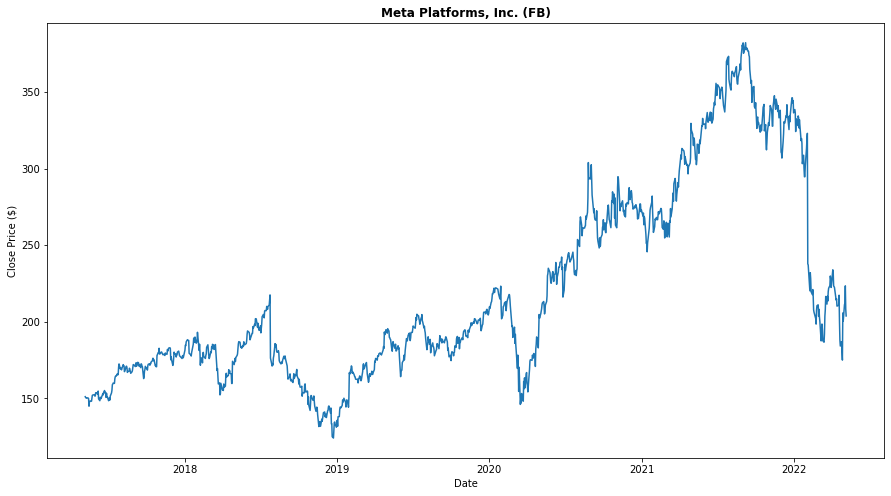

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                 1260
Model:                      ETS(AAdN)   Log Likelihood               -3938.797
Date:                Mon, 09 May 2022   AIC                           7889.593
Time:                        11:37:16   BIC                           7920.426
Sample:                             0   HQIC                          7901.180
                               - 1260   Scale                           30.392
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9439      0.027     34.369      0.000       0.890       0.998
smoothing_trend  9.439e-05        nan        nan        nan         nan         nan
damping_trend       0.8000      

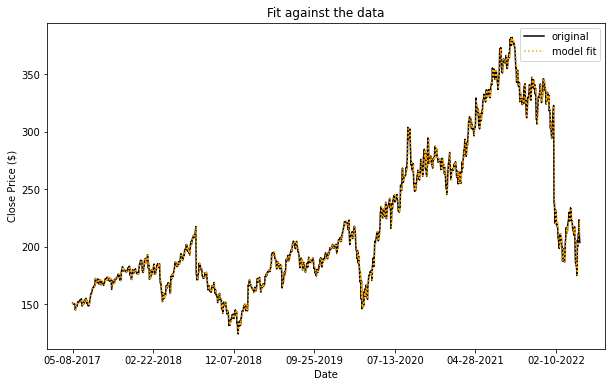

,mean,pi_lower,pi_upper
1260,204.068185,193.263102,214.873268
1261,204.068038,189.208907,218.927168
1262,204.067920,186.044295,222.091544
1263,204.067825,183.357467,224.778184
1264,204.067750,180.981057,227.154443
1265,204.067690,178.827272,229.308107
1266,204.067641,176.843252,231.292031
1267,204.067603,174.994239,233.140966
1268,204.067572,173.255933,234.879210
1269,204.067547,171.610553,236.524540


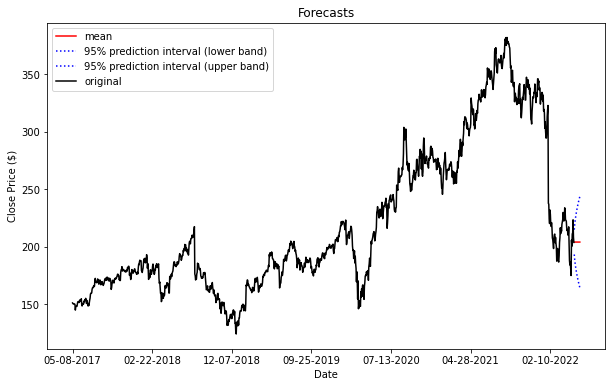

 
Stock: JPMorgan BetaBuilders U.S. Equity ETF
 
//////////////////////////////////////////////////////////////////////////////////////////////////////////////
 
Ticker Symbol: BBUS
Type: Exchange Traded Fund (ETF)
Fund Family: JPMorgan
Total Number of Assets: 1081726976
 
Summary: The underlying index is a free float adjusted market capitalization weighted index which consists of equity securities primarily traded in the United States. The underlying index targets 85% of those stocks by market capitalization, and primarily includes large- and mid-cap companies. The fund will invest at least 80% of its assets in securities included in the underlying index.
 
//////////////////////////////////////////////////////////////////////////////////////////////////////////////
 
Holdings: [{'symbol': 'AAPL', 'holdingName': 'Apple Inc', 'holdingPercent': 0.0556}, {'symbol': 'MSFT', 'holdingName': 'Microsoft Corp', 'holdingPercent': 0.052800003}, {'symbol': 'AMZN', 'holdingName': 'Amazon.com Inc',

Number of missing data records from Close: 0
Number of missing data records from Date: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    796 non-null    datetime64[ns]
 1   Close   796 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.6 KB
None


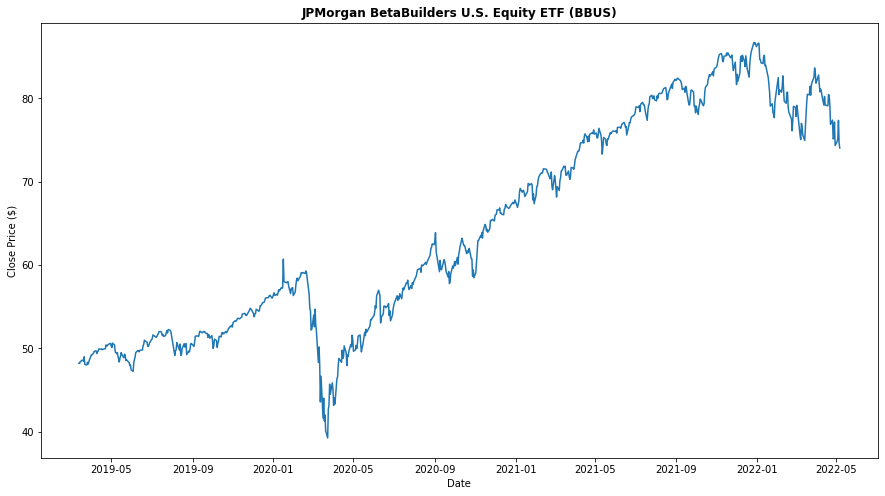

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  796
Model:                      ETS(AAdN)   Log Likelihood                -961.464
Date:                Mon, 09 May 2022   AIC                           1934.929
Time:                        11:37:24   BIC                           1963.006
Sample:                             0   HQIC                          1945.717
                                - 796   Scale                            0.656
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.8342      0.061     13.649      0.000       0.714       0.954
smoothing_trend     0.0441      0.080      0.552      0.581      -0.112       0.200
damping_trend       0.8000      

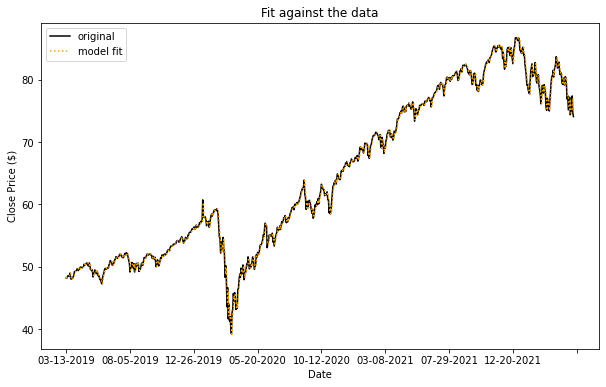

,mean,pi_lower,pi_upper
796,74.130946,72.543927,75.717965
797,74.073692,71.970653,76.176731
798,74.027889,71.487728,76.568051
799,73.991247,71.061169,76.921325
800,73.961933,70.675177,77.248690
801,73.938482,70.320618,77.556346
802,73.919721,69.991505,77.847937
803,73.904712,69.683586,78.125839
804,73.892705,69.393669,78.391742
805,73.883100,69.119272,78.646928


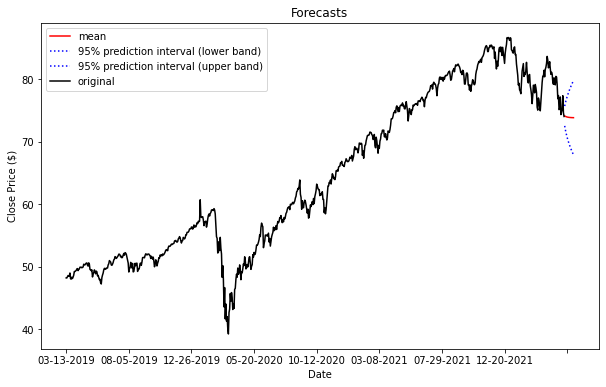

 
Stock: Rocket Lab USA, Inc.
 
//////////////////////////////////////////////////////////////////////////////////////////////////////////////
 
Ticker Symbol: RKLB
Industry: Aerospace & Defense
Address: 3881 McGowen Street, Long Beach, CA, United States
 
Summary: Rocket Lab USA, Inc., a space company, provides launch services and space systems solutions for the space and defense industries. The company provides launch services, spacecraft engineering and design services, spacecraft components, spacecraft manufacturing, and other spacecraft and on-orbit management solutions; and constellation management services, as well as designs and manufactures small and medium-class rockets. It also designs, manufactures, and sells Electron small orbital launch vehicles and the Photon satellite platforms, as well as developing the Neutron 8-ton payload class launch vehicle; conducts remote launch activities; and designs and manufactures a range of components and subsystems for the Photon family o

Number of missing data records from Close: 0
Number of missing data records from Date: 0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    365 non-null    datetime64[ns]
 1   Close   365 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB
None


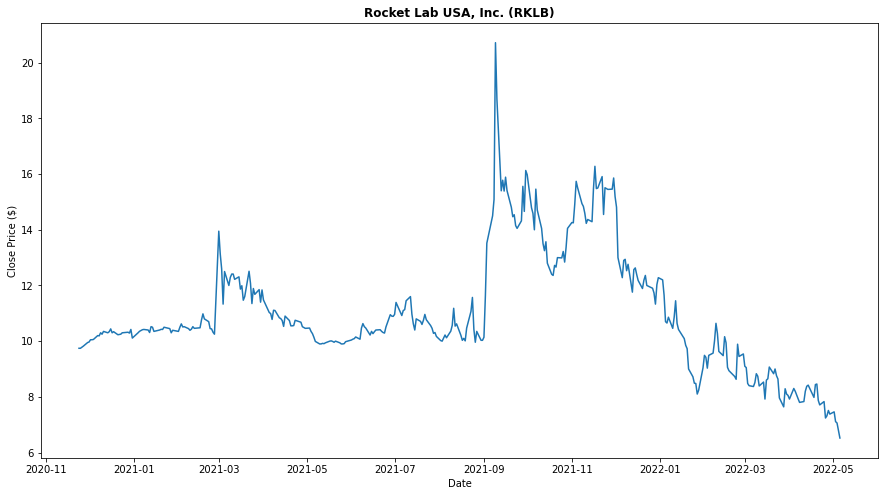

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  365
Model:                      ETS(AAdN)   Log Likelihood                -321.595
Date:                Mon, 09 May 2022   AIC                            655.190
Time:                        11:37:32   BIC                            678.590
Sample:                             0   HQIC                           664.489
                                - 365   Scale                            0.341
Covariance Type:               approx                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9356      0.060     15.554      0.000       0.818       1.053
smoothing_trend  9.356e-05        nan        nan        nan         nan         nan
damping_trend       0.9674      

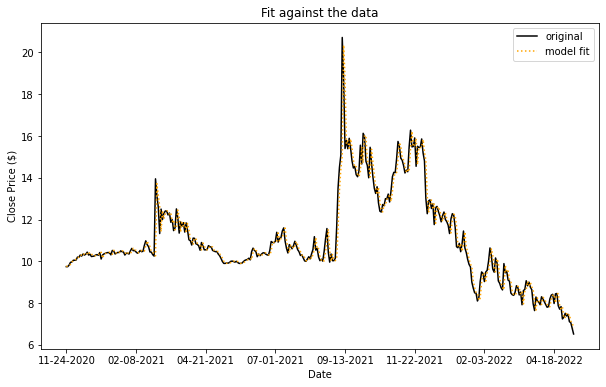

,mean,pi_lower,pi_upper
365,6.537726,5.393109,7.682343
366,6.537542,4.970004,8.105080
367,6.537363,4.638833,8.435894
368,6.537191,4.357313,8.717069
369,6.537024,4.108131,8.965917
370,6.536863,3.882175,9.191550
371,6.536706,3.673946,9.399467
372,6.536555,3.479823,9.593288
373,6.536409,3.297273,9.775546
374,6.536268,3.124440,9.948096


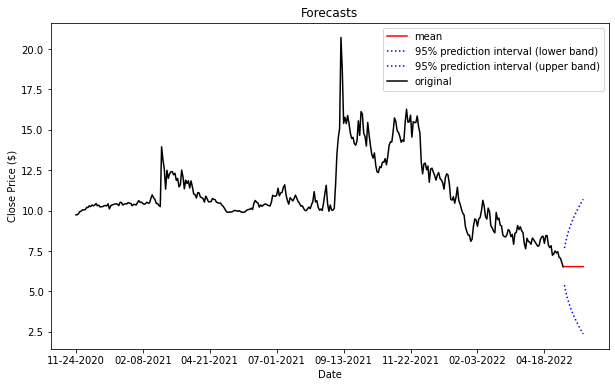

In [180]:
# all calls and input requests for the user

# user enters number of stocks to see 
how_many = input('Enter how many stocks: ')

# creates an array that will hold user input for ticker symbols 
list_of_tickers = []
for h in range(int(how_many)):
    input_ticker = input('Enter ticker symbol: ')
    list_of_tickers.append(input_ticker.upper())

# presentation info
print('The tool will be run for ' + str(how_many) + ' stock/s')
print('The stock/s -> ' + str(list_of_tickers))
print('\n')

# function calls 
for call_num in range(len(list_of_tickers)):
    df, df_volume, name, ticker_symbol, ticker = get_and_prep_dataset(list_of_tickers = list_of_tickers, call_num = call_num)
    get_company_info(ticker)
    show_visual(df, df_volume, name, ticker_symbol)

    see_data(df)
    secondary_visualizations(df, ticker)
    the_model(df)

